In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

FIG_DIR = "assets/figures"
TAB_DIR = "assets/tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

- [X] Reshape from wide → long format (`Country`, `Year`, `GDP_per_capita`).
- [X] Handle missing values:
  - [X] Drop countries with >30% missing data.
  - [X] Fill missing GDP values with linear interpolation.

In [163]:
df = pd.read_csv("./data/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_122367.csv", skiprows=4)

In [164]:
data = df.copy()
years = [c for c in data.columns if c.isdigit()]


In [165]:
data.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,27441.529662,28440.051964,30082.127645,31096.205074,22855.932320,27200.061079,30559.533535,33984.790620,NaN,NaN
1,Africa Eastern and Southern,AFE,GDP per capita (current US$),NY.GDP.PCAP.CD,186.121835,186.941781,197.402402,225.440494,208.999748,226.876513,...,1329.807285,1520.212231,1538.901679,1493.817938,1344.103210,1522.393346,1628.318944,1568.159891,1673.841139,NaN
2,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,522.082216,525.469771,491.337221,496.602504,510.787063,356.496214,357.261153,413.757895,NaN,NaN
3,Africa Western and Central,AFW,GDP per capita (current US$),NY.GDP.PCAP.CD,121.939925,127.454189,133.827044,139.008291,148.549379,155.565216,...,1630.039447,1574.230560,1720.140280,1798.340685,1680.039332,1765.954788,1796.668633,1599.392983,1284.154441,NaN
4,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1807.952941,2437.259712,2538.591391,2189.855714,1449.922867,1925.874661,2929.694455,2309.534130,2122.083690,NaN


In [166]:
# Reshape from wide → long format (`Country`, `Year`, `GDP_per_capita`).
#rows = []
#for row in data.iterrows():
#    country = row[1]["Country Name"]
#    country_code = row[1]["Country Code"]
#    for year in range(1960, 2025):
#        new_row = {"Country": country,
#                  "Country_Code": country_code,
#                 "Year": year,
#                   "GDP_per_capita": row[1][str(year)]}
#        rows.append(new_row)
#data_long = pd.DataFrame(rows)
#data_long = data_long.reset_index(drop=True)

In [167]:
data_long = data.melt(
    id_vars=["Country Name", "Country Code"],
    value_vars=years,
    var_name="Year",
    value_name="GDP_per_capita"
)
data_long["Year"] = data_long["Year"].astype(np.int64)
data_long.rename({"Country Name": "Country", "Country Code": "Country_Code"}, axis=1, inplace=True)
data_long.reset_index(drop=True, inplace=True)

In [168]:
# Handle missing values:
#   Drop countries with >30% missing data.
#   Fill missing GDP values with linear interpolation.# Convert Year column to integer and GDP to numeric.

missing = data_long.groupby("Country")["GDP_per_capita"].apply(lambda x: x.isna().sum())
size = data_long.groupby("Country").size()
missing_ratio = missing / size

In [169]:
countries_to_drop = missing_ratio[missing_ratio > 0.3].index
data_long = data_long[~data_long["Country"].isin(countries_to_drop)].copy()

In [170]:
data_long["GDP_per_capita"] = data_long.sort_values(["Country", "Year"]).groupby("Country")["GDP_per_capita"].transform(
    lambda x: x.interpolate(limit_direction="both"))

- [X] Compute the **global mean GDP per capita** per year (line plot).
- [X] Identify the **richest 10 and poorest 10 countries** in the latest available year.
- [X] Compute **year-to-year percentage growth** for a few sample countries.
- [X] Use NumPy to:
  - [X] Calculate global mean, median, and standard deviation for each year.
  - [X] Identify years with unusually high volatility (std dev spikes).

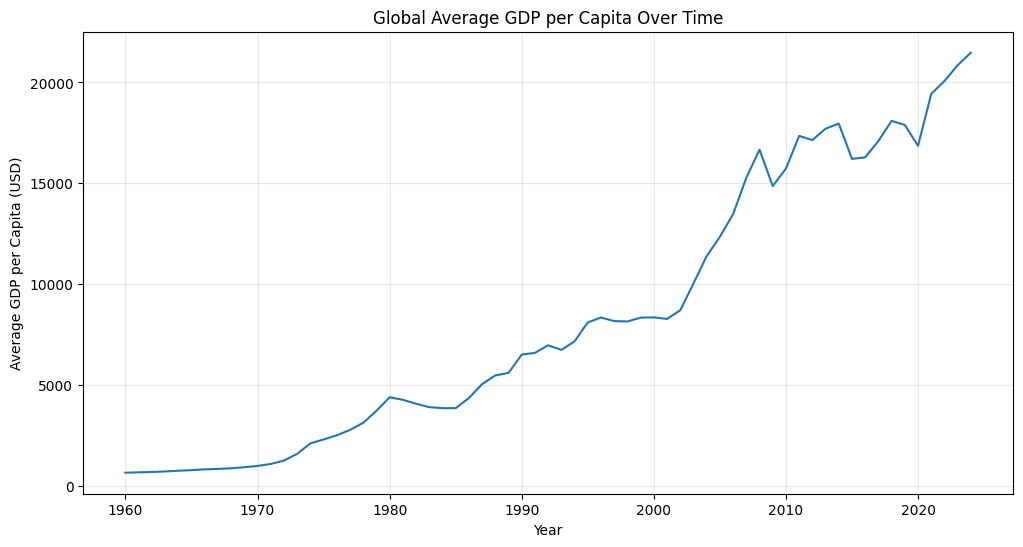

In [171]:
# Compute the global mean GDP per capita per year (line plot).
global_gdp_per_year = (
    data_long.groupby("Year")["GDP_per_capita"]
    .mean()
    .sort_index()
)

plt.figure(figsize=(12, 6))
plt.plot(global_gdp_per_year.index, global_gdp_per_year.values, color="tab:blue")
plt.title("Global Average GDP per Capita Over Time")
plt.xlabel("Year")
plt.ylabel("Average GDP per Capita (USD)")
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(FIG_DIR, "global_gdp_per_year.png"), dpi=300, bbox_inches="tight")
plt.show()

In [172]:
#  Identify the richest 10 and poorest 10 countries in the latest available year.
latest_year = data_long["Year"].max()
latest_year_gdp_data = data_long[data_long["Year"] == latest_year].dropna().sort_values(
    "GDP_per_capita", ascending=False)
poorest_ten = latest_year_gdp_data.tail(10)
richest_ten = latest_year_gdp_data.head(10)

poorest_ten.to_csv(os.path.join(TAB_DIR, "poorest_ten.csv"), index=False)
richest_ten.to_csv(os.path.join(TAB_DIR, "richest_ten.csv"), index=False)
poorest_ten, richest_ten

(                        Country Country_Code  Year  GDP_per_capita
 17251      Syrian Arab Republic          SYR  2024      847.372723
 17155                   Liberia          LBR  2024      846.277368
 17198                   Nigeria          NGA  2024      806.945695
 17160                Low income          LIC  2024      746.934789
 17197                     Niger          NER  2024      722.748650
 17067          Congo, Dem. Rep.          COD  2024      647.435705
 17237                   Somalia          SOM  2024      636.983478
 17175                Madagascar          MDG  2024      544.997303
 17058  Central African Republic          CAF  2024      516.170425
 17040                   Burundi          BDI  2024      153.930218,
              Country Country_Code  Year  GDP_per_capita
 17173         Monaco          MCO  2024   256580.515123
 17161  Liechtenstein          LIE  2024   207973.617747
 17051        Bermuda          BMU  2024   138934.958846
 17168     Luxembourg  

In [173]:
# Compute year-to-year percentage growth for a few sample countries.
countries = np.array(["China", "United States", "Germany", "Turkiye"])
pct_growth_per_year = pd.DataFrame(columns=countries, index=years)

for country in countries:
    country_data = data_long[data_long["Country"] == country].sort_values("Year").reset_index(drop=True)
    pct_growth = country_data["GDP_per_capita"].pct_change()
    pct_growth_per_year[country] = pct_growth.values

pct_growth_per_year

,China,United States,Germany,Turkiye
1960,NaN,NaN,NaN,NaN
1961,-0.153258,0.020281,0.132331,0.027181
1962,-0.064553,0.058402,0.087098,0.087079
1963,0.047937,0.040563,0.050075,0.130025
1964,0.150305,0.059201,0.090071,0.051468
...,...,...,...,...
2020,0.027513,-0.012670,-0.005126,-0.062580
2021,0.212654,0.107232,0.103122,0.127851
2022,0.006454,0.091905,-0.049354,0.095584
2023,-0.001498,0.057072,0.085623,0.227753


In [174]:
# Use NumPy to:
#   Calculate global mean, median, and standard deviation for each year.
#   Identify years with unusually high volatility (std dev spikes).
data_long.groupby("Year")["GDP_per_capita"].mean()

Year
1960      647.261238
1961      666.326766
1962      683.979601
1963      709.723329
1964      745.955024
            ...     
2020    16861.256596
2021    19431.656910
2022    20073.703925
2023    20857.713208
2024    21475.690248
Name: GDP_per_capita, Length: 65, dtype: float64

In [175]:
data_long.groupby("Year")["GDP_per_capita"].median()


Year
1960     269.038073
1961     279.016489
1962     285.473073
1963     291.800007
1964     305.532203
           ...     
2020    5722.480995
2021    6681.708952
2022    6909.352818
2023    7000.836605
2024    7466.651865
Name: GDP_per_capita, Length: 65, dtype: float64

In [176]:
gdp_std_per_year = data_long.groupby("Year")["GDP_per_capita"].std()
gdp_std_per_year

Year
1960     1124.981351
1961     1133.786970
1962     1144.724342
1963     1153.564929
1964     1179.580961
            ...     
2020    25993.682178
2021    30944.304290
2022    31091.932692
2023    33058.525884
2024    33610.095278
Name: GDP_per_capita, Length: 65, dtype: float64

In [177]:
volatility_threshold = gdp_std_per_year.mean() + 2 * gdp_std_per_year.std()
gdp_std_per_year[gdp_std_per_year > volatility_threshold]

Year
2024    33610.095278
Name: GDP_per_capita, dtype: float64

- [X] Add a mapping: Country → Continent (manual or external dataset).
- [X] Group by continent:
  - [X] Compute average GDP per capita per year.
  - [X] Plot trend lines for each continent (one line per continent).

In [178]:
continents_data = pd.read_csv("./data/country-and-continent-codes-list.csv")

In [179]:
# Add a mapping: Country → Continent (manual or external dataset).
data_long = data_long.merge(
    continents_data,
    left_on="Country_Code",
    right_on="Three_Letter_Country_Code",
    how="left")[["Country", "Continent_Name", "Year", "GDP_per_capita"]]

In [180]:
# Group by continent:
# - Compute average GDP per capita per year.
# - Plot trend lines for each continent (one line per continent).
continent_trends = data_long.groupby(["Continent_Name", "Year"])["GDP_per_capita"].mean().reset_index().sort_values(
    ["Year", "Continent_Name"])
# Save continent trends table
continent_trends.to_csv(os.path.join(TAB_DIR, "continent_trends.csv"), index=False)
continent_trends

,Continent_Name,Year,GDP_per_capita
0,Africa,1960,179.659377
65,Asia,1960,636.473861
130,Europe,1960,1782.347708
195,North America,1960,731.484666
260,Oceania,1960,935.844807
...,...,...,...
129,Asia,2024,21463.675311
194,Europe,2024,71958.128810
259,North America,2024,25965.893333
324,Oceania,2024,15240.746181


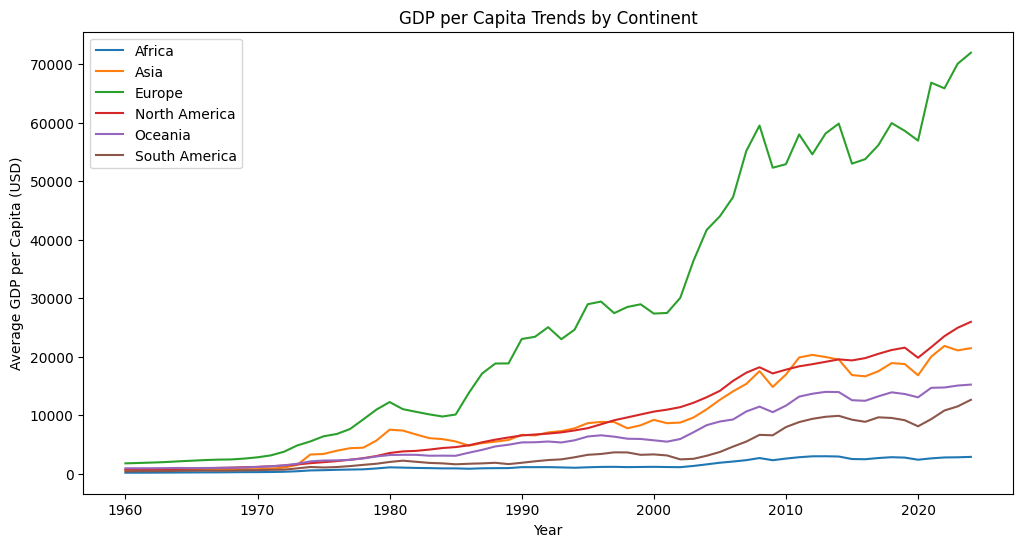

In [181]:
plt.figure(figsize=(12, 6))

for continent in continent_trends["Continent_Name"].unique():
    subset = continent_trends[continent_trends["Continent_Name"] == continent]
    plt.plot(subset["Year"], subset["GDP_per_capita"], label=continent)

plt.title("GDP per Capita Trends by Continent")
plt.xlabel("Year")
plt.ylabel("Average GDP per Capita (USD)")
plt.legend()
# Save figure before showing
plt.savefig(os.path.join(FIG_DIR, "continent_trends.png"), dpi=200, bbox_inches="tight")
plt.show()

- [X] Standardize GDP per capita (z-score) for a given year.
- [X] Identify outliers (countries >3 std deviations from mean).

In [182]:
# Standardize GDP per capita (z-score) for a given year.
year = np.random.randint(data_long["Year"].min(), data_long["Year"].max(), 1)[0]
random_year_data = data_long[data_long["Year"] == year].copy()
mean = random_year_data["GDP_per_capita"].mean()
std = random_year_data["GDP_per_capita"].std()
random_year_data["z_score"] = (random_year_data["GDP_per_capita"] - mean) / std
random_year_data

,Country,Continent_Name,Year,GDP_per_capita,z_score
402,Africa Eastern and Southern,NaN,1962,197.402402,-0.426602
403,Africa Western and Central,NaN,1962,133.827044,-0.482394
404,Andorra,Europe,1962,3935.411278,2.853791
405,Arab World,NaN,1962,210.805415,-0.414839
406,United Arab Emirates,Asia,1962,2394.068115,1.501143
...,...,...,...,...,...
598,World,NaN,1962,495.786854,-0.164746
599,Samoa,Oceania,1962,321.996707,-0.317260
600,South Africa,Africa,1962,563.423009,-0.105390
601,Zambia,Africa,1962,202.281031,-0.422320


In [183]:
# Identify outliers (countries >3 std deviations from mean).
random_year_data[np.abs(random_year_data["z_score"]) > 3]

,Country,Continent_Name,Year,GDP_per_capita,z_score
501,Kuwait,Asia,1962,4748.392844,3.567246
508,Liechtenstein,Europe,1962,4262.032206,3.140427
516,Monaco,Europe,1962,12098.201875,10.017274


- [X] Line plot: GDP trends of top 5 largest economies (US, China, Japan, Germany, India).
- [X] Histogram: Distribution of GDP per capita for all countries in 2020.
- [X] Scatter plot: GDP per capita vs Year for China and India (compare growth paths).
- [X] Rolling mean (5-year window) for global GDP per capita trend (smooth line plot).

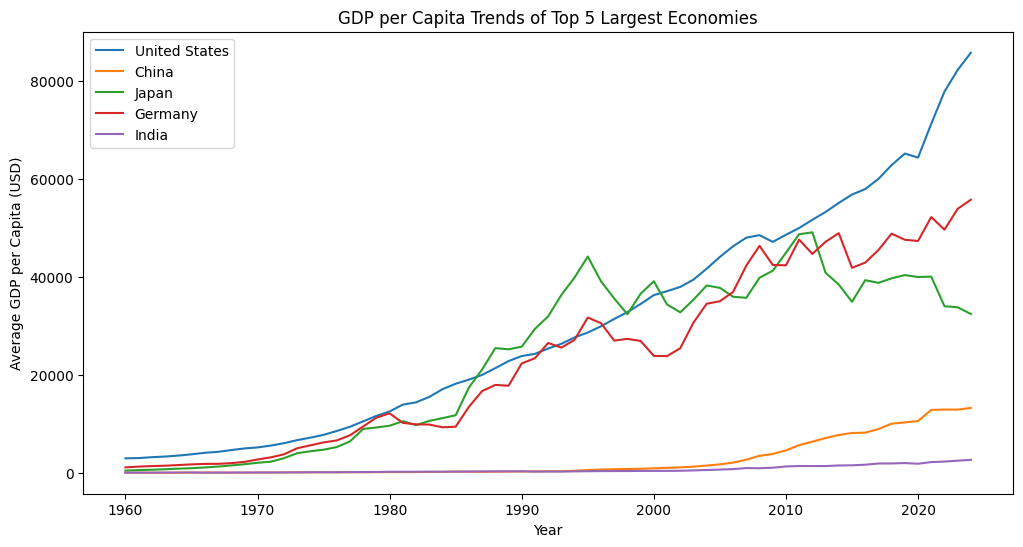

In [184]:
# GDP trends of top 5 largest economies (US, China, Japan, Germany, India).
countries = np.array(["United States", "China", "Japan", "Germany", "India"])

plt.figure(figsize=(12, 6))
largest_economies_data = data_long[data_long["Country"].isin(countries)]
for country in countries:
    subset = largest_economies_data[largest_economies_data["Country"] == country]
    plt.plot(subset["Year"], subset["GDP_per_capita"], label=country)

plt.title("GDP per Capita Trends of Top 5 Largest Economies")
plt.xlabel("Year")
plt.ylabel("Average GDP per Capita (USD)")
plt.legend()
plt.savefig(os.path.join(FIG_DIR, "gdp_trends_of_top_5_largest_economies.png"), dpi=300, bbox_inches="tight")
plt.show()


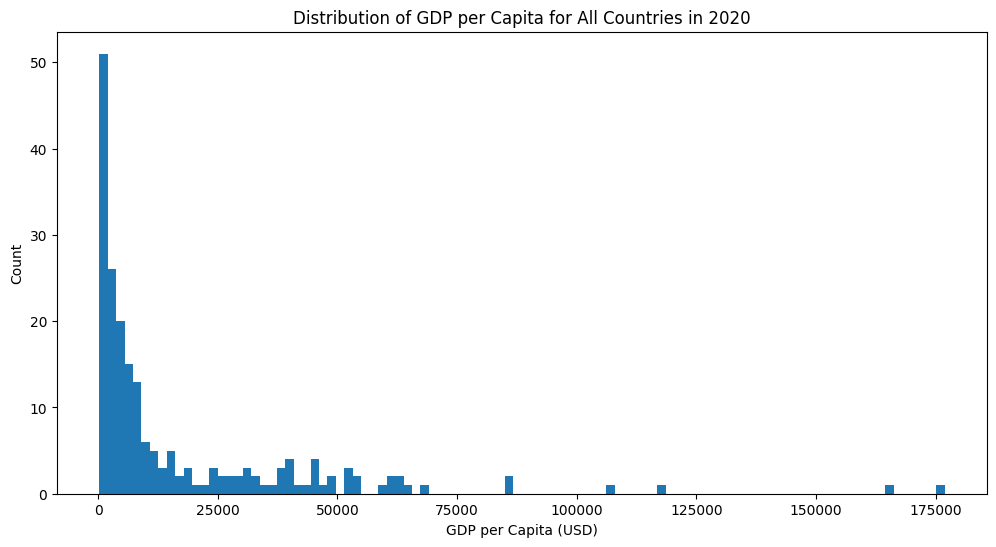

In [185]:
# Histogram: Distribution of GDP per capita for all countries in 2020.
certain_year_data = data_long[data_long["Year"] == 2020]

plt.figure(figsize=(12, 6))
plt.hist(certain_year_data["GDP_per_capita"], bins=100)
plt.title("Distribution of GDP per Capita for All Countries in 2020")
plt.xlabel("GDP per Capita (USD)")
plt.ylabel("Count")
plt.savefig(os.path.join(FIG_DIR, "distribution_of_gdp_per_capita_for_all_countries_in_2020.png"),
            dpi=300,
            bbox_inches="tight")
plt.show()

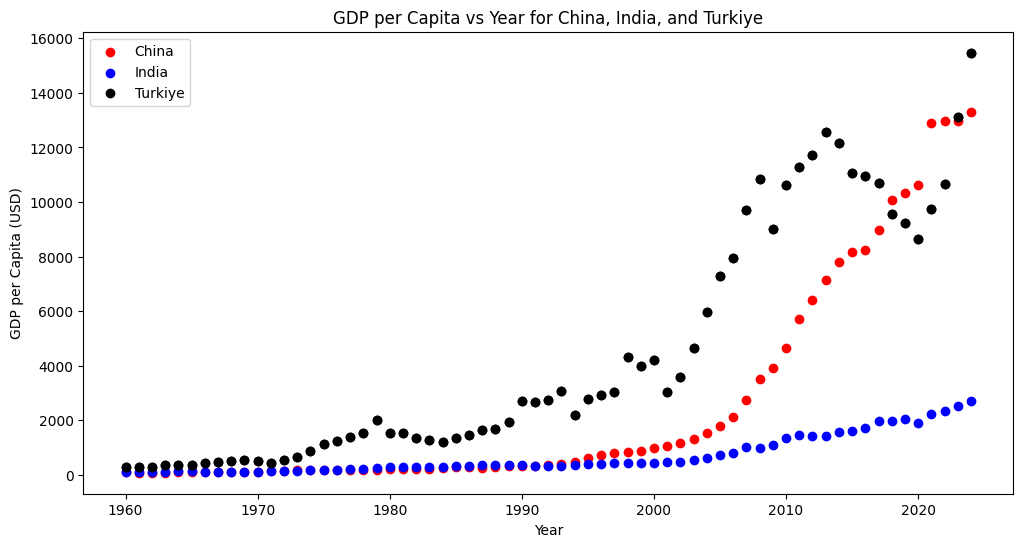

In [186]:
# Scatter plot: GDP per capita vs Year for China, India and, Turkiye (compare growth paths).
china_data = data_long[data_long["Country"] == "China"]
india_data = data_long[data_long["Country"] == "India"]
turkiye_data = data_long[data_long["Country"] == "Turkiye"]

plt.figure(figsize=(12, 6))
plt.scatter(china_data["Year"], china_data["GDP_per_capita"], label="China", color="red")
plt.scatter(india_data["Year"], india_data["GDP_per_capita"], label="India", color="blue")
plt.scatter(turkiye_data["Year"], turkiye_data["GDP_per_capita"], label="Turkiye", color="black")
plt.title("GDP per Capita vs Year for China, India, and Turkiye")
plt.xlabel("Year")
plt.ylabel("GDP per Capita (USD)")
plt.legend()
# Save figure before showing
plt.savefig(os.path.join(FIG_DIR, "gdp_per_capita_vs_year_for_china_india_and_turkiye.png"), dpi=200,
            bbox_inches="tight")
plt.show()

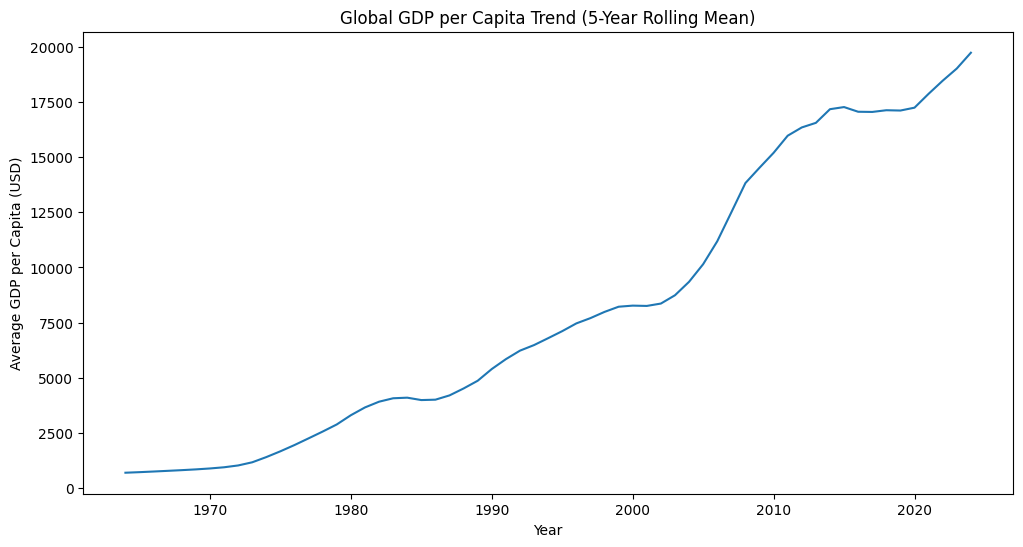

In [187]:
# Rolling mean (5-year window) for global GDP per capita trend (smooth line plot).
global_gdp_per_year_smoothed = global_gdp_per_year.rolling(5).mean()
plt.figure(figsize=(12, 6))
plt.plot(global_gdp_per_year_smoothed)
plt.title("Global GDP per Capita Trend (5-Year Rolling Mean)")
plt.xlabel("Year")
plt.ylabel("Average GDP per Capita (USD)")
plt.savefig(os.path.join(FIG_DIR, "global_gdp_per_capita_trend_5_year_rolling_mean.png"), dpi=200, bbox_inches="tight")
plt.show()
